# brazilHousingTrends
- Sara Echeverría 21371
- Ricardo Mendez 21289

Repository link: https://github.com/bl33h/brazilHousingTrends

## análisis exploratorio

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/data.csv')

In [3]:
# display the first few rows of the dataset
print(data.head())

# statistical summary of numerical variables
print(data.describe())

# check for missing values in the dataset
print(data.isnull().sum())

# exclude non-numerical columns for correlation analysis
numericalData = data.select_dtypes(include=[np.number])

           city  area  rooms  bathroom  parking spaces floor     animal  \
0     São Paulo    70      2         1               1     7      acept   
1     São Paulo   320      4         4               0    20      acept   
2  Porto Alegre    80      1         1               1     6      acept   
3  Porto Alegre    51      2         1               0     2      acept   
4     São Paulo    25      1         1               0     1  not acept   

       furniture  hoa (R$)  rent amount (R$)  property tax (R$)  \
0      furnished      2065              3300                211   
1  not furnished      1200              4960               1750   
2  not furnished      1000              2800                  0   
3  not furnished       270              1112                 22   
4  not furnished         0               800                 25   

   fire insurance (R$)  total (R$)  
0                   42        5618  
1                   63        7973  
2                   41        3841 

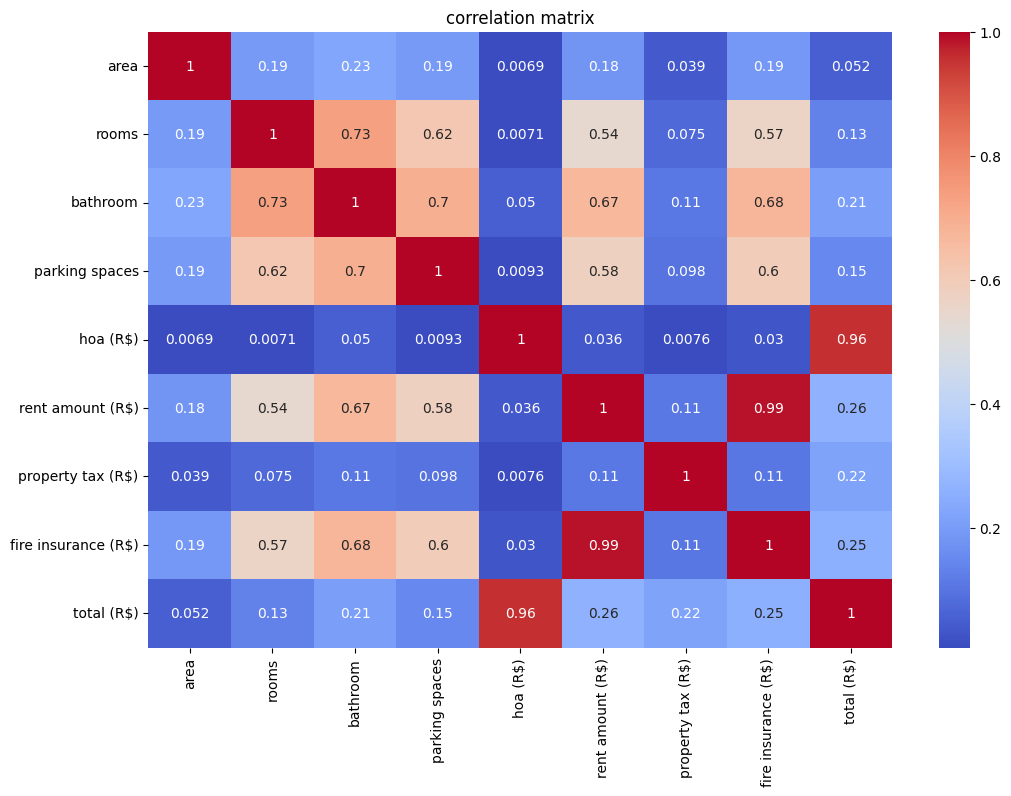

In [4]:
# correlation analysis between features
correlationMatrix = numericalData.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm')
plt.title('correlation matrix')
plt.show()

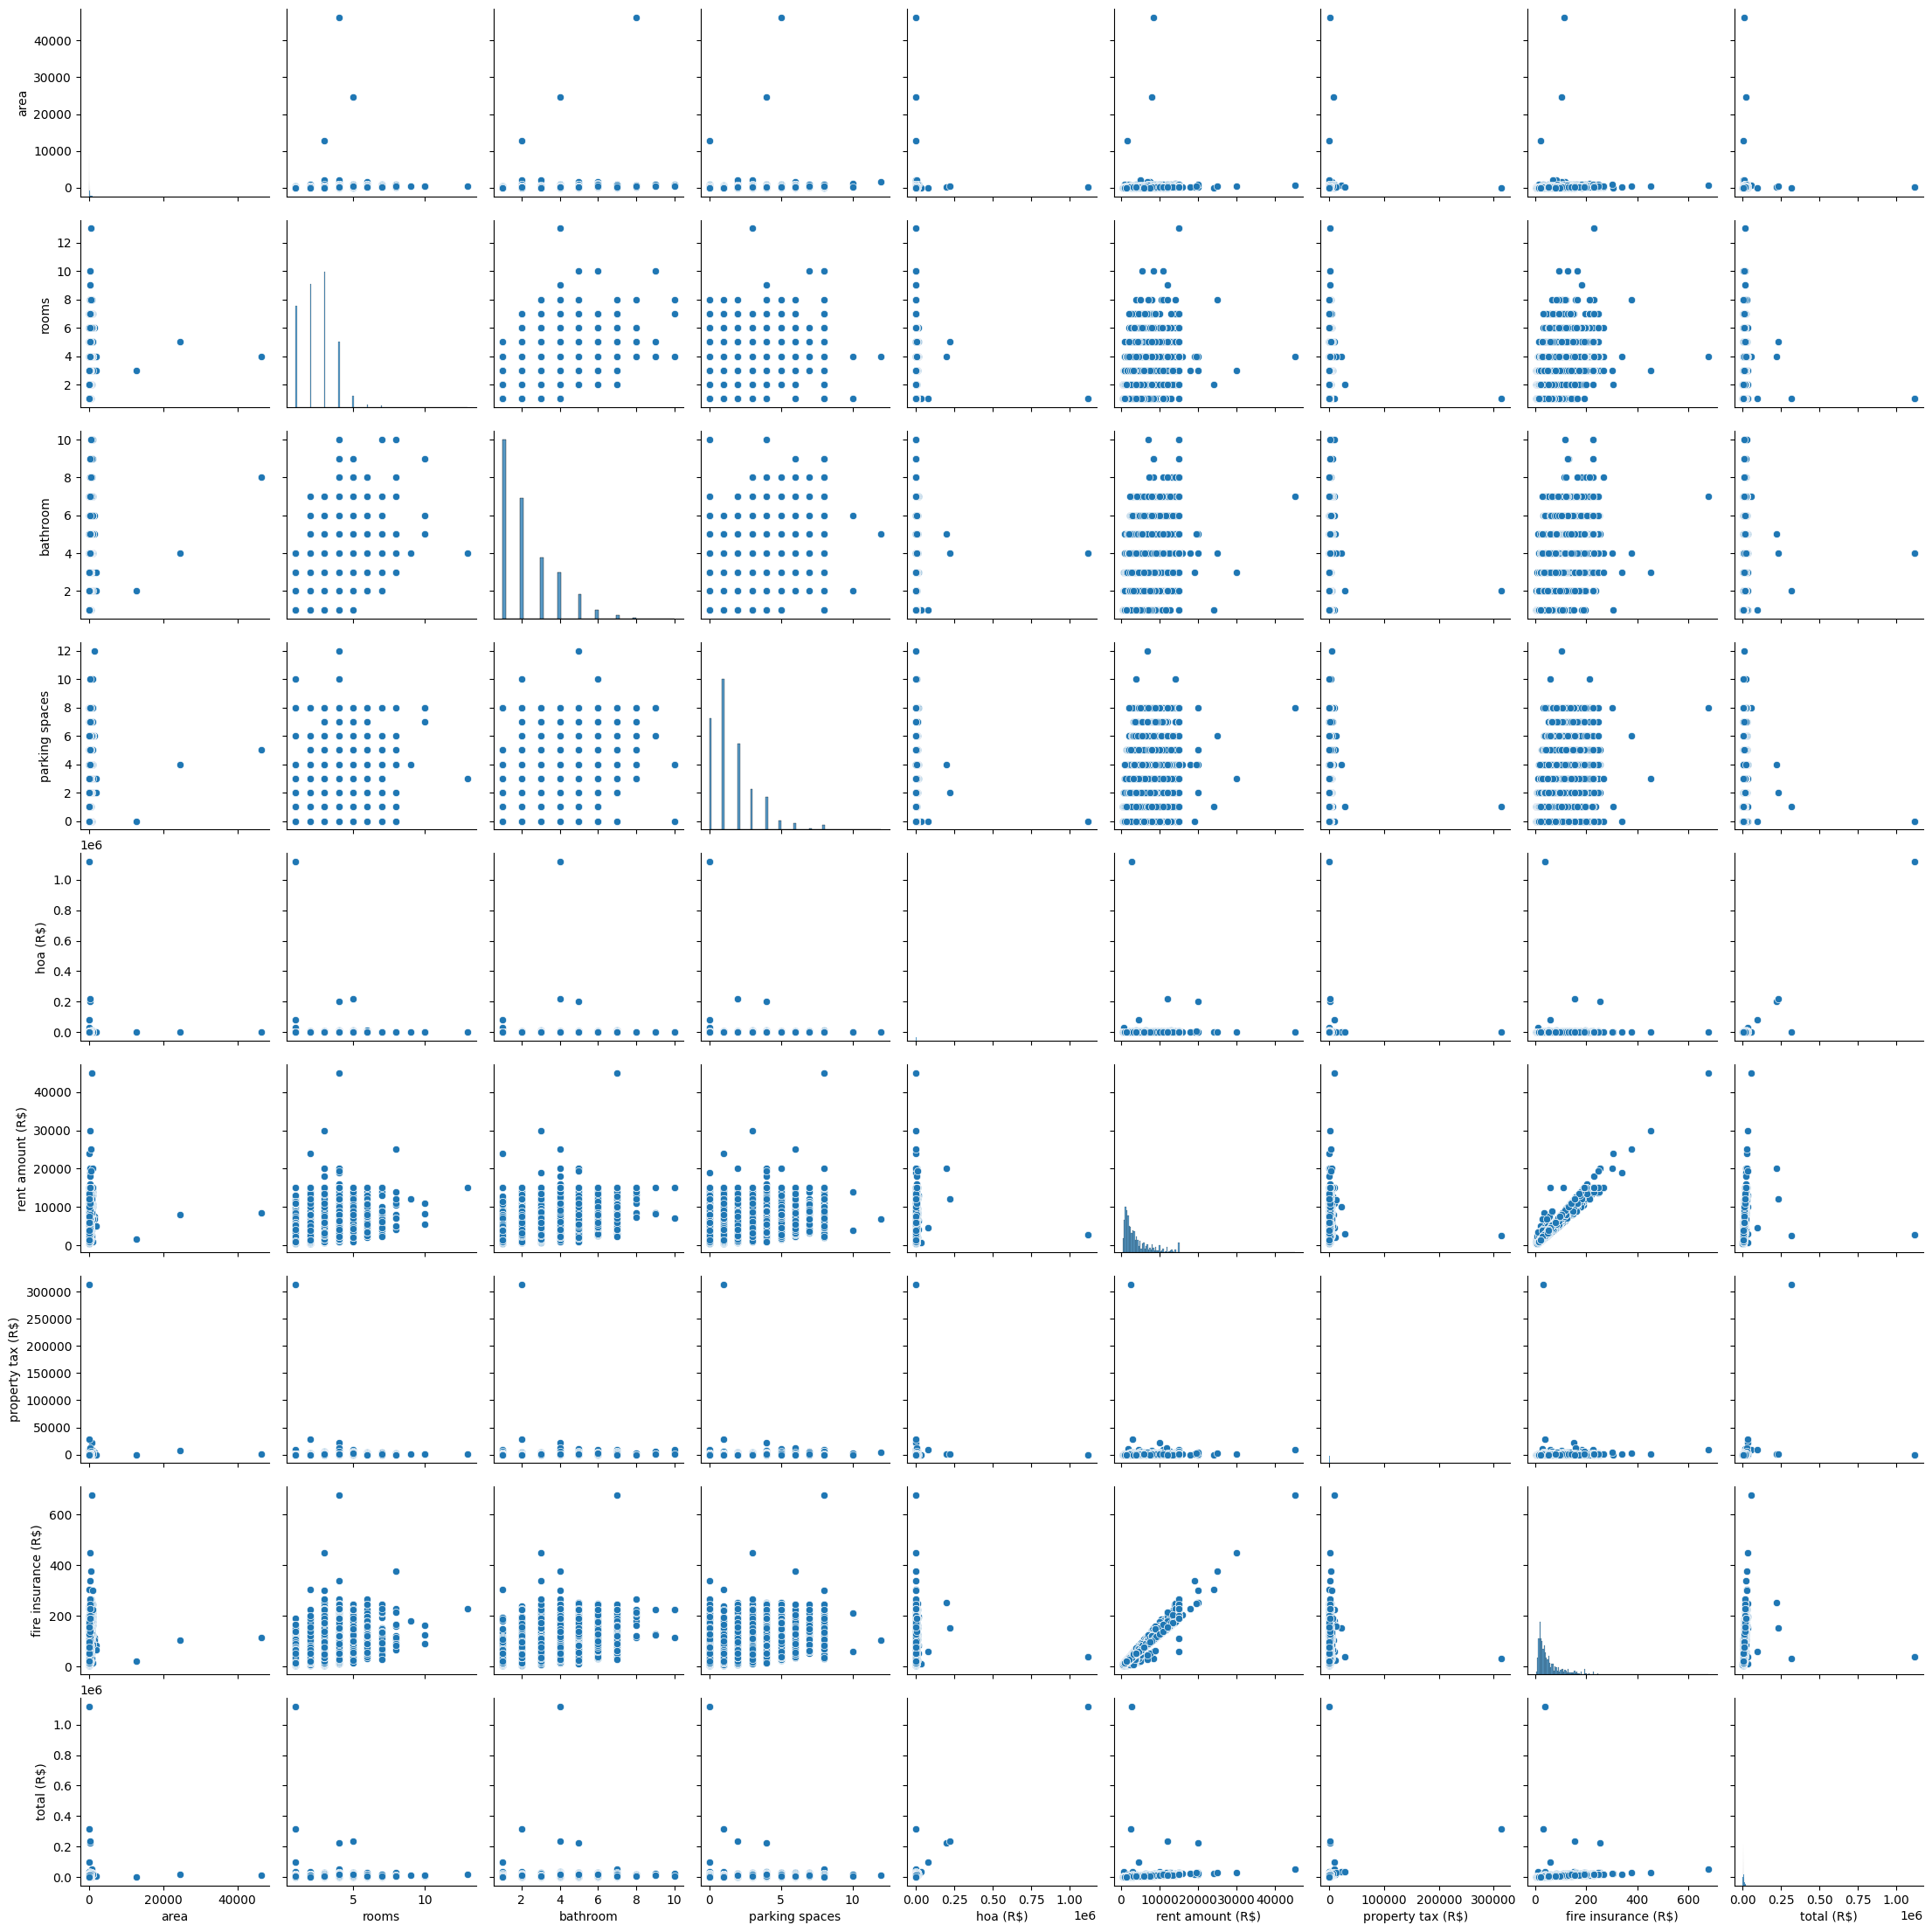

In [5]:
# visualization of numerical variables distributions
sns.pairplot(data)
plt.show()

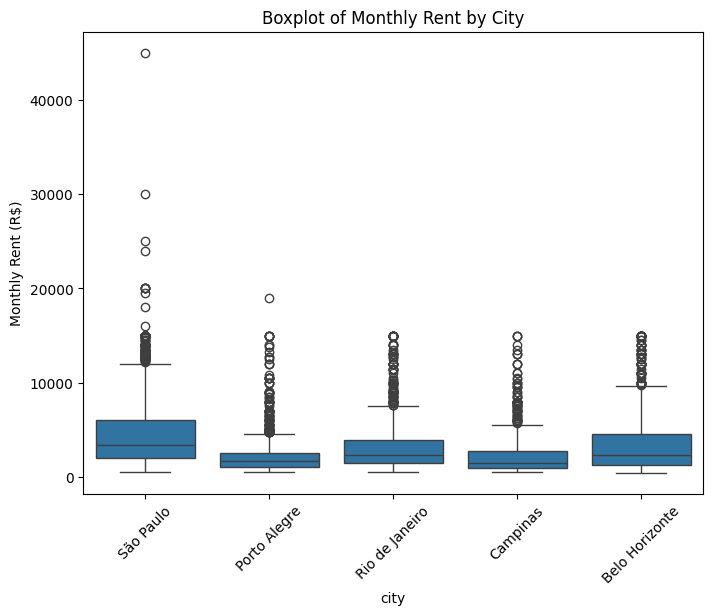

In [6]:
# boxplots to identify outliers in rents
plt.figure(figsize=(8, 6))
sns.boxplot(x='city', y='rent amount (R$)', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot of Monthly Rent by City')
plt.ylabel('Monthly Rent (R$)')
plt.show()

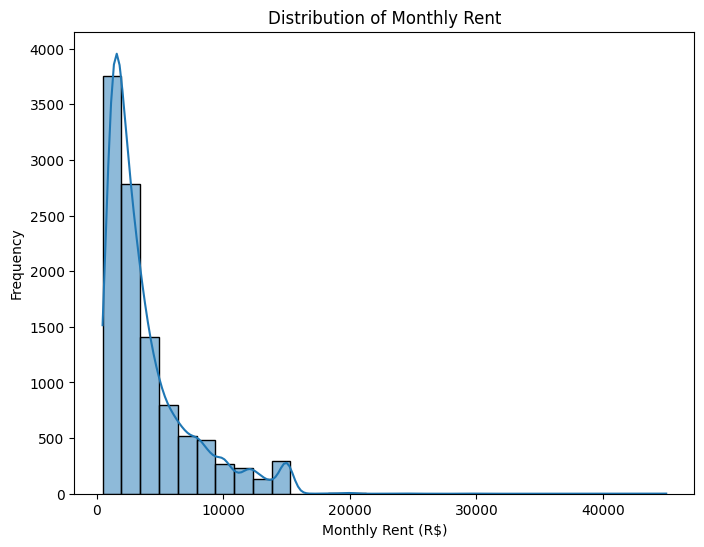

In [7]:
# analysis of the distribution of 'rent amount (R$)'
plt.figure(figsize=(8, 6))
sns.histplot(data['rent amount (R$)'], bins=30, kde=True)
plt.title('Distribution of Monthly Rent')
plt.xlabel('Monthly Rent (R$)')
plt.ylabel('Frequency')
plt.show()

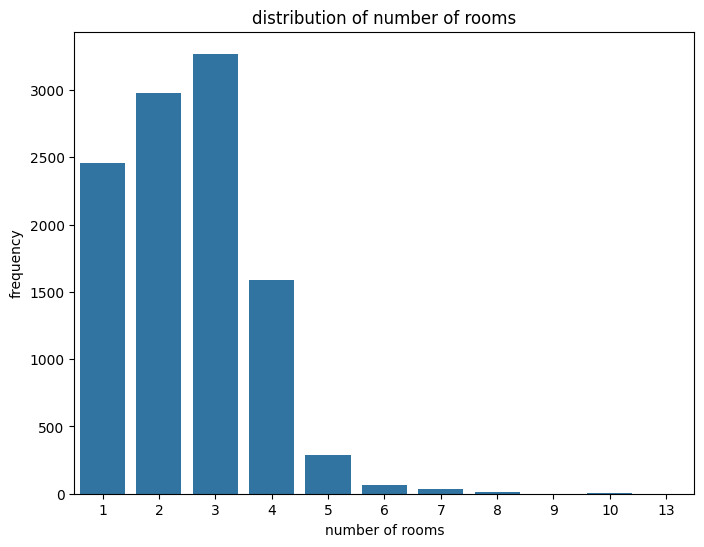

In [8]:
# distribution of the number of rooms
plt.figure(figsize=(8, 6))
sns.countplot(x='rooms', data=data)
plt.title('distribution of number of rooms')
plt.xlabel('number of rooms')
plt.ylabel('frequency')
plt.show()

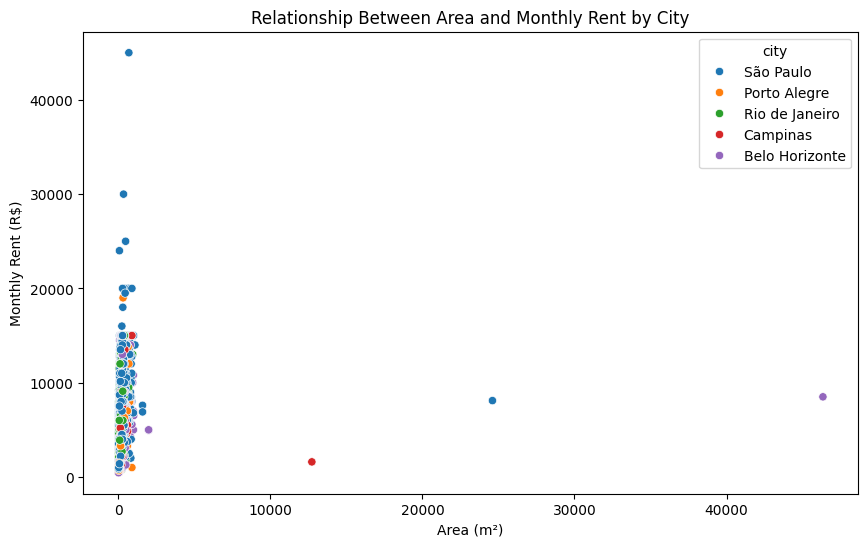

In [9]:
# explore the relationship between area and monthly rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='rent amount (R$)', hue='city', data=data)
plt.title('Relationship Between Area and Monthly Rent by City')
plt.xlabel('Area (m²)')
plt.ylabel('Monthly Rent (R$)')
plt.show()

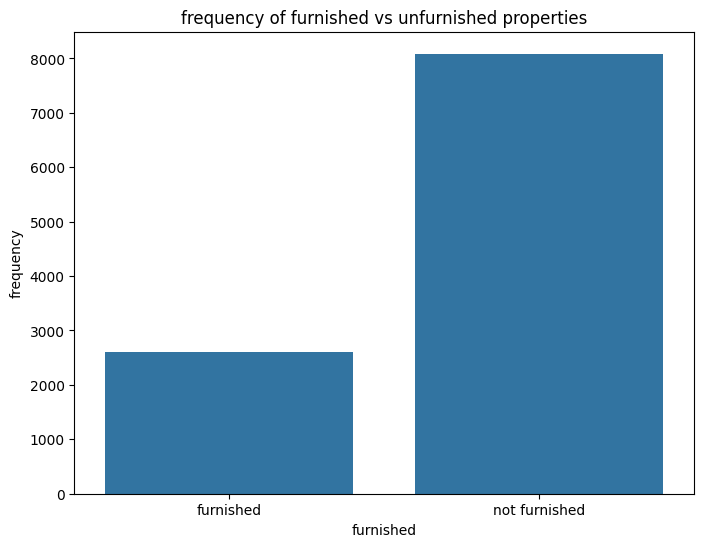

In [10]:
# evaluation of the categorical variable 'furniture'
plt.figure(figsize=(8, 6))
sns.countplot(x='furniture', data=data)
plt.title('frequency of furnished vs unfurnished properties')
plt.xlabel('furnished')
plt.ylabel('frequency')
plt.show()

### hallazgos
- Predominan los alquileres bajos con algunos valores altos que representan propiedades de lujo.
- São Paulo muestra mayor variabilidad en rentas; otras ciudades tienen distribuciones más uniformes.
- La mayoría de las propiedades tienen entre 1 y 3 habitaciones.
- Áreas mayores generalmente corresponden a rentas más altas, aunque con excepciones.
- Hay más propiedades no amuebladas que amuebladas, indicando una preferencia por la flexibilidad o costos más bajos.

## preprocesamiento y limpieza de datos

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [12]:
# handling outliers in rent amount using IQR
Q1 = data['rent amount (R$)'].quantile(0.25)
Q3 = data['rent amount (R$)'].quantile(0.75)
IQR = Q3 - Q1
lowerBound = Q1 - 1.5 * IQR
upperBound = Q3 + 1.5 * IQR
data = data[(data['rent amount (R$)'] >= lowerBound) & (data['rent amount (R$)'] <= upperBound)]

# encode categorical variables
categoricalFeatures = ['city', 'animal', 'furniture']
numericalFeatures = ['area', 'rooms', 'bathroom', 'parking spaces', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)']

# apply one-hot encoding to categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericalFeatures),
        ('cat', OneHotEncoder(), categoricalFeatures)
    ])

# fit and transform the data
dataProcessed = preprocessor.fit_transform(data)

# convert the array back to a dataframe if needed
columnNames = numericalFeatures + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categoricalFeatures))
dataProcessed = pd.DataFrame(dataProcessed, columns=columnNames)

# display the processed data
print(dataProcessed.head())

       area     rooms  bathroom  parking spaces  hoa (R$)  rent amount (R$)  \
0 -0.117100 -0.370641 -0.847289       -0.317060  0.062855          0.034307   
1  0.336917  1.411472  1.479549       -0.996611  0.008299          0.757332   
2 -0.098940 -1.261697 -0.847289       -0.317060 -0.004315         -0.183471   
3 -0.151606 -0.370641 -0.847289       -0.996611 -0.050357         -0.918692   
4 -0.198824 -1.261697 -0.847289       -0.996611 -0.067386         -1.054585   

   property tax (R$)  fire insurance (R$)  city_Belo Horizonte  city_Campinas  \
0          -0.028333            -0.060433                  0.0            0.0   
1           0.454015             0.593515                  0.0            0.0   
2          -0.094463            -0.091573                  0.0            0.0   
3          -0.087568            -0.838942                  0.0            0.0   
4          -0.086628            -1.025784                  0.0            0.0   

   city_Porto Alegre  city_Rio de Jane

In [13]:
# splitting features and target from the processed DataFrame
x = dataProcessed.drop('rent amount (R$)', axis=1)
y = dataProcessed['rent amount (R$)']

## modelos

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [26]:
# split data into training and test sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)
xTest

,area,rooms,bathroom,parking spaces,hoa (R$),property tax (R$),fire insurance (R$),city_Belo Horizonte,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,animal_acept,animal_not acept,furniture_furnished,furniture_not furnished
5825,-0.008136,0.520416,-0.071676,-0.996611,-0.032697,-0.027079,0.531234,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5171,0.010024,1.411472,0.703936,0.362491,-0.002423,-0.025512,0.032988,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6041,0.010024,1.411472,0.703936,0.362491,0.058755,0.010218,0.157550,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
107,-0.098940,-0.370641,-0.071676,0.362491,-0.014911,-0.040869,-0.496398,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3422,-0.180663,-1.261697,-0.847289,-0.996611,-0.067386,-0.094463,-0.838942,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,0.218872,1.411472,1.479549,1.721592,-0.067386,0.023068,0.250971,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
7095,-0.135261,-0.370641,-0.847289,-0.996611,-0.067386,-0.065002,-0.838942,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3838,0.197079,1.411472,1.479549,1.721592,0.109212,0.297307,2.804481,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9901,-0.098940,-1.261697,-0.847289,1.721592,-0.067386,-0.070957,-0.870083,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


### regresión lineal

In [16]:
linearModel = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linearModel.fit(xTrain, yTrain)
yPredLinear = linearModel.predict(xTest)
linearRmse = np.sqrt(mean_squared_error(yTest, yPredLinear))
linearMae = mean_absolute_error(yTest, yPredLinear)
linearR2 = r2_score(yTest, yPredLinear)
print("Linear Regression RMSE:", linearRmse)
print("Linear Regression MAE:", linearMae)
print("Linear Regression R²:", linearR2)

Linear Regression RMSE: 0.16507632493110372
Linear Regression MAE: 0.10803993331244154
Linear Regression R²: 0.9721471787171423


### random forest

In [17]:
rfModel = RandomForestRegressor(n_estimators=100, random_state=42)
rfModel.fit(xTrain, yTrain)
yPredRf = rfModel.predict(xTest)
rfRmse = np.sqrt(mean_squared_error(yTest, yPredRf))
rfMae = mean_absolute_error(yTest, yPredRf)
rfR2 = r2_score(yTest, yPredRf)
print("Random Forest RMSE:", rfRmse)
print("Random Forest MAE:", rfMae)
print("Random Forest R²:", rfR2)

Random Forest RMSE: 0.10219695842942539
Random Forest MAE: 0.030210220764818146
Random Forest R²: 0.9893248115517437


### Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbModel = GradientBoostingRegressor(n_estimators=100, random_state=42)

gbModel.fit(xTrain, yTrain)

yPredGb = gbModel.predict(xTest)

gbRmse = np.sqrt(mean_squared_error(yTest, yPredGb))
gbMae = mean_absolute_error(yTest, yPredGb)
gbR2 = r2_score(yTest, yPredGb)

print("Gradient Boosting RMSE:", gbRmse)
print("Gradient Boosting MAE:", gbMae)
print("Gradient Boosting R²:", gbR2)

Gradient Boosting RMSE: 0.10123391798204652
Gradient Boosting MAE: 0.043725459818672464
Gradient Boosting R²: 0.9895250562410626


En todas las métricas se puede ver que el modelo de Regresión lineal es el peor de los 3 con un margen de diferencia considerable. Luego, Random Forest y Gradient Boosting están muy cerca el uno del otro, siendo este segundo un poco mejor. Además, es el que menos tiempo requiere por lo que sería el seleccionado para el ambiente de producción.

### Export model

In [19]:
import joblib
joblib.dump(gbModel, 'gbModel.pkl')

['gbModel.pkl']